# Crimes in Atlanta

## A Project in R by Nimish Ojale and Sukhada Saoji

#### In this project we evaluate the crime data collected from Atlanta Police Department and examine the effects of several location and time-based parameters on the occurrence and type of crime.

## MOTIVATION

#### Atlanta, the capital and most populous city of the state of Georgia, is the 6th most dangerous city in the country according to this report. The rate of crime is more than twice of the national average, with 5203 violent crimes and 25,556 property crimes reported in the year 2015. Our motivation for deciding to work on the data of crimes committed in Atlanta in the previous year was to analyze the distribution of crimes by region, time, and type of crimes committed, among other variables, and try to develop a predictive model towards predicting the type of crime that might be committed given the variables stated above.


## DATA EXPLORATION

#### The data has been collected from Atlanta Police Department’s website. It consists of 26,760 data points, i.e., instances of recorded crimes, and 23 columns consisting of fields related to occurrence of crime, type of crime, location codes, neighborhood in which the crime took place, etc.


In [26]:
## Loading libraries

library('data.table')
library('ggplot2')
library('lubridate')
library('plotly')
library('magrittr')
library('dplyr')
library('tidyverse')
library('cluster')    
library('factoextra')
library('dendextend')
library('mlbench')
library('caret')
library('inTrees')
library('randomForest')
library('ISLR')
library('nnet')
library('MASS')
library('data.table')
library('neuralnet')
library('stats')
library('mlbench')
library('caret')
library('inTrees')
library('e1071')
library('class')

Warning message:
"package 'e1071' was built under R version 3.4.4"

#### Loading data and removing null values

In [32]:
main = read.csv("F:/2018 Spring/STAT689/Project/689_crimes.csv", header = TRUE, sep = ",")

In [33]:
## Counting number of "na" rows in data

count = 0

for(i in 1:nrow(main)) {
    for(j in 1:ncol(main)) {
        
    if(is.na(main[i,j]) == "TRUE") {
        count = count + 1
    }
       }
    }

count

[1] 64

In [34]:
## removing rows with null values

nullval = matrix(, nrow = 64, ncol = 2)
count = 0
for(i in 1:nrow(main)) {
    for(j in 1:ncol(main)) {
        
    if(is.na(main[i,j]) == "TRUE") {
        count = count + 1
        nullval[count,1] = i
        nullval[count,2] = j
    }
       }
    }

main = main[-nullval[,1],]

In [35]:
## We focus on the top 25 most crime-ridden neighborhoods

neighbor25 = main %>% 
filter(!is.na(neighborhood)) %>%  
group_by(neighborhood) %>% 
summarise(total=n()) %>% 
arrange(desc(total)) %>%
top_n(25)

Selecting by total


In [36]:
n25 = neighbor25[,1]

In [37]:
main25 = main[which(main$neighborhood == "Downtown" |
                    main$neighborhood == "Midtown" |
                    main$neighborhood == "Old Fourth Ward" |
                    main$neighborhood == "Lindbergh/Morosgo" |
                    main$neighborhood == "West End" |
                    main$neighborhood == "Lenox" |
                    main$neighborhood == "North Buckhead" |
                    main$neighborhood == "Edgewood" |
                    main$neighborhood == "Greenbriar" |
                    main$neighborhood == "Home Park" |
                    main$neighborhood == "Mechanicsville" |
                    main$neighborhood == "Princeton Lakes" |
                    main$neighborhood == "Vine City" |
                    main$neighborhood == "Sylvan Hills" |
                    main$neighborhood == "Inman Park" |
                    main$neighborhood == "Grant Park" |
                    main$neighborhood == "Berkeley Park" |
                    main$neighborhood == "Morningside/Lenox Park" |
                    main$neighborhood == "Grove Park" |
                    main$neighborhood == "Lakewood Heights" |
                    main$neighborhood == "Castleberry Hill" |
                    main$neighborhood == "Pittsburgh" |
                    main$neighborhood == "East Atlanta" |
                    main$neighborhood == "Underwood Hills" |
                    main$neighborhood == "Blandtown"),]

In [38]:
## main25 now contains only 10939 crime reports

nrow(main25)

[1] 10939

## Now we explore the data using visualizations

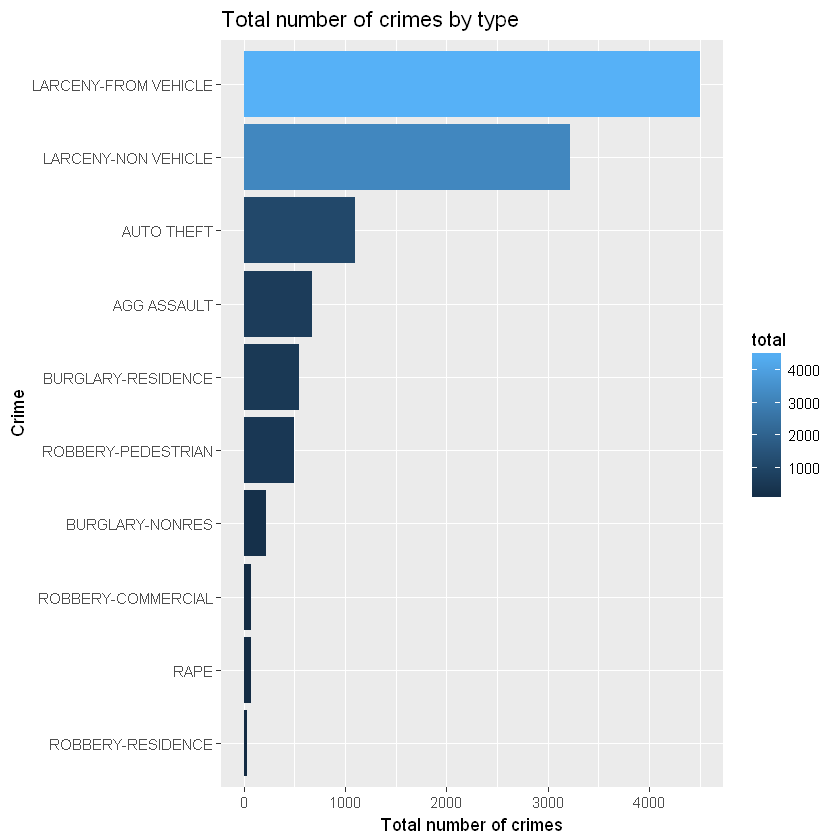

In [39]:
crimetype = main25 %>% 
group_by(UC2.Literal) %>% 
summarise(total=n()) %>% 
arrange(desc(total)) %>%
ggplot(aes(reorder(UC2.Literal, total), y = total, fill = total)) + 
geom_bar(stat = "identity") +  
coord_flip() +
labs(x = "Crime", y = "Total number of crimes", title = "Total number of crimes by type")

crimetype

Selecting by total


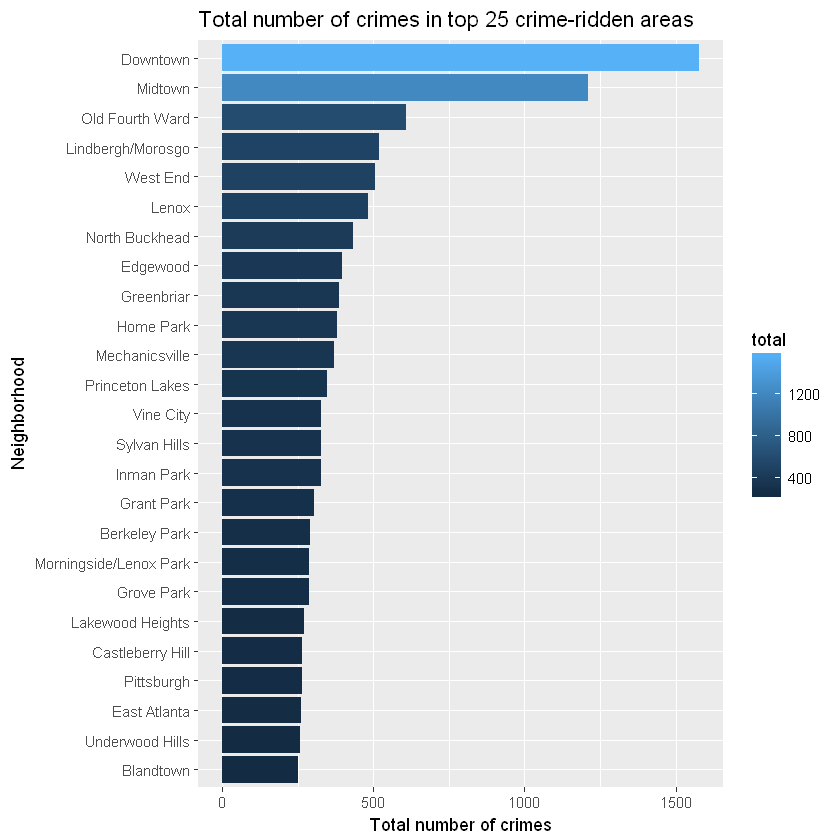

In [40]:
neighbor = main25 %>% 
group_by(neighborhood) %>% 
summarise(total=n()) %>% 
arrange(desc(total)) %>%
top_n(25) %>%
ggplot(aes(reorder(neighborhood, total), y = total, fill = total)) + 
geom_bar(stat = "identity") +  
coord_flip() +
labs(x = "Neighborhood", y = "Total number of crimes", title = "Total number of crimes in top 25 crime-ridden areas")

neighbor

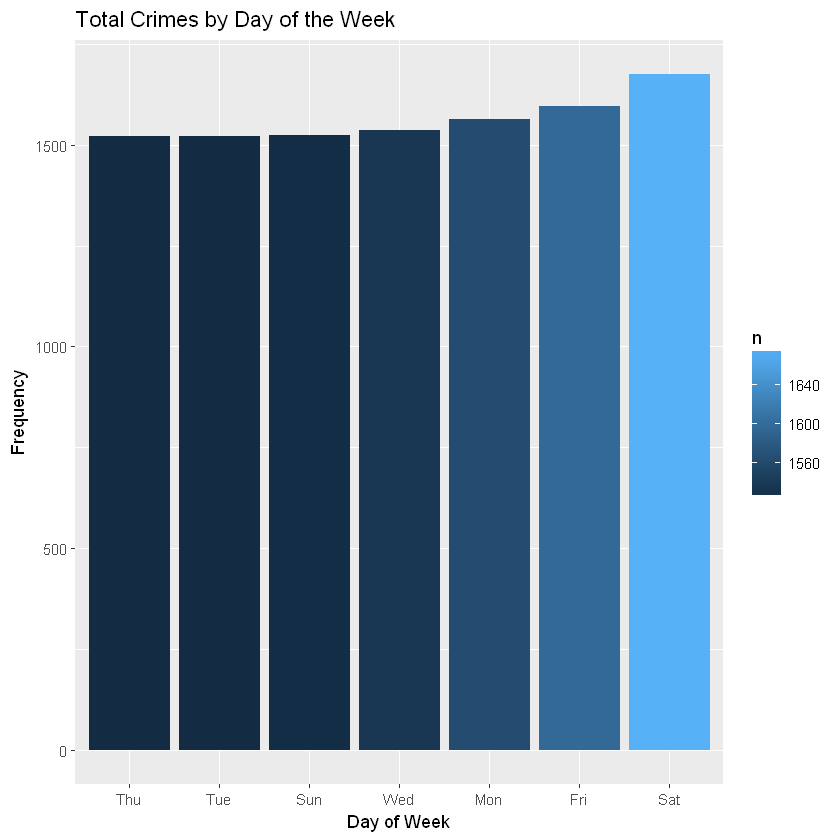

In [41]:
week.day = main25 %>%
  group_by(Avg.Day) %>%
  count() %>%
  ggplot(aes(x = reorder(Avg.Day, n), y = n, fill = n)) +   
  geom_bar(stat = "identity", position = "dodge") +
  xlab("Day of Week") +
  ylab("Frequency") +
  ggtitle("Total Crimes by Day of the Week")

week.day

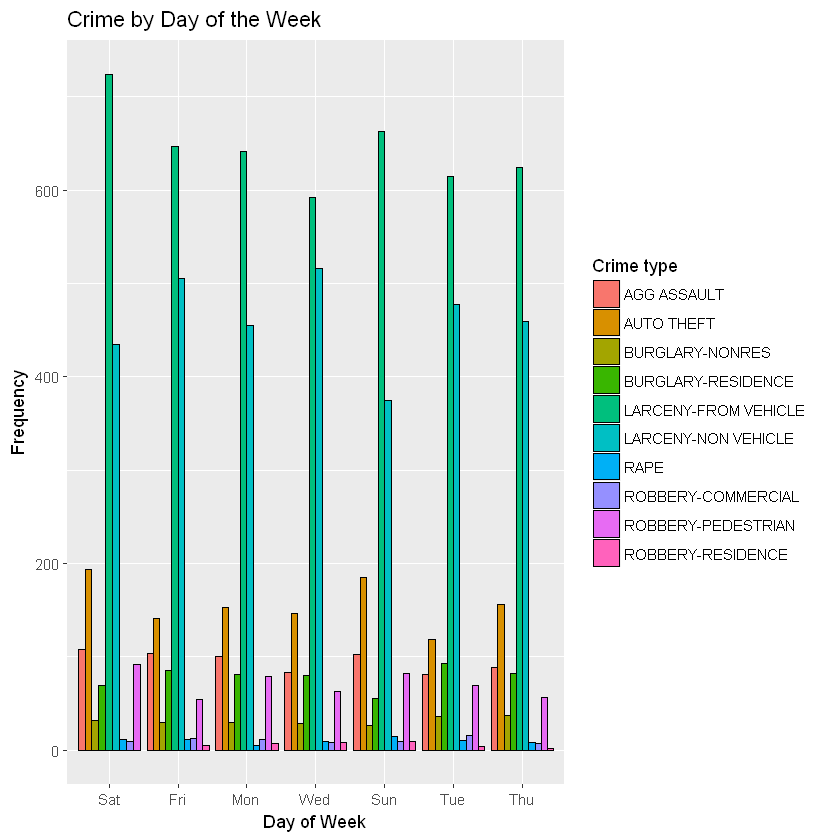

In [42]:
day_break = main25 %>%
group_by(Avg.Day, UC2.Literal ) %>%
summarize(n = n()) %>%
ggplot(aes(reorder(Avg.Day, -n), y = n, fill = n)) +   
geom_bar(aes(fill = UC2.Literal), position = "dodge", stat = "identity", color = "black") +
labs( x = "Day of Week", y = "Frequency", title = "Crime by Day of the Week", fill = "Crime type")


day_break

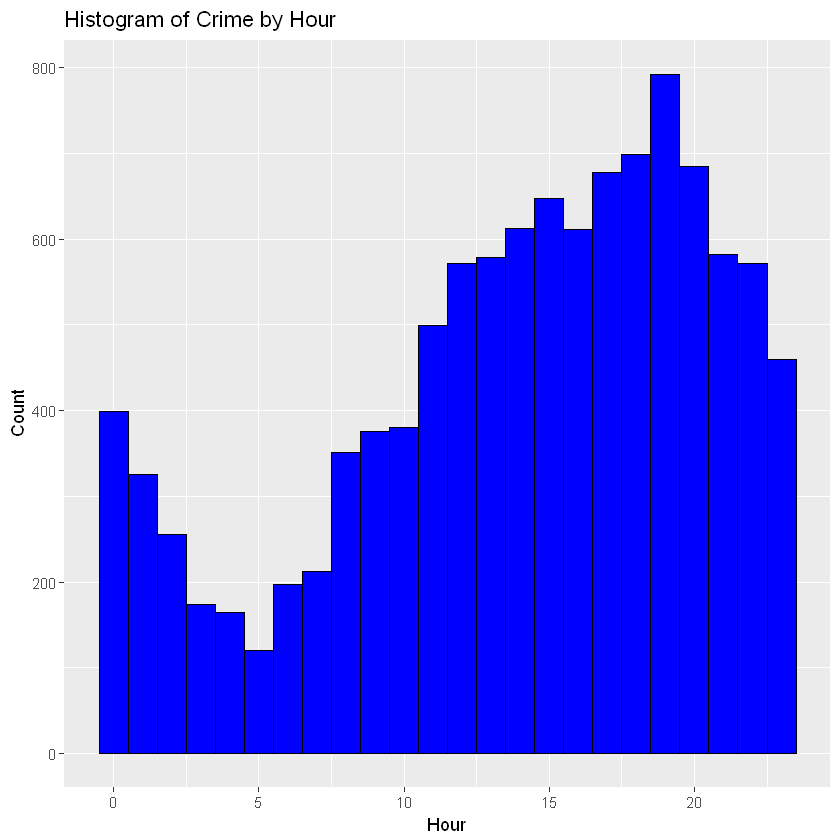

In [43]:
main25$hour = as.numeric(sub(":.*", "", main25$occur_time))

hour = ggplot(main25, aes(x = hour)) + 
  geom_histogram(bins = 24, color = "black", fill = "blue") +
  xlab("Hour") + 
  ylab("Count") +
  ggtitle('Histogram of Crime by Hour') 

hour

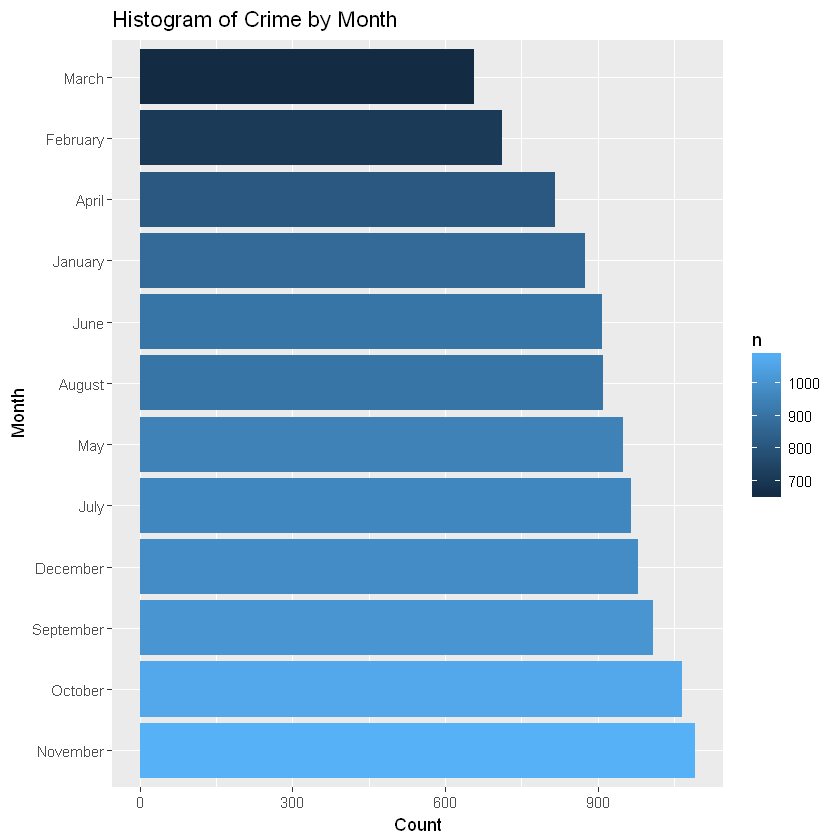

In [44]:
# ## Histogram of month v/s crimes

months = main25 %>%
group_by(Month) %>%
  count() %>%
  ggplot(aes(x = reorder(Month, -n), y = n, fill = n)) +
  geom_bar(stat = "identity", position = "dodge") +
  xlab(c("Month")) + 
  ylab("Count") +
  ggtitle('Histogram of Crime by Month') +
coord_flip()

months

## Predictive modeling

### We build classification models using time and location based predictors to predict the type of crime that will have taken place given those predictors

### Starting with Multinomial Regression model

In [45]:
## We divide the data into training and validation sets

set.seed(10)
train = sample(nrow(main25), (nrow(main25)/2))
train.set = main25[train,]

## Converting all categorical variabe values into factors

train.set = transform(train.set, UC2.Literal = factor(UC2.Literal), neighborhood = factor(neighborhood), Shift = factor(Shift))

## Releveling response classes with respect to a reference class

train.set$UC2.Literal = relevel(train.set$UC2.Literal, ref = "AUTO THEFT")

## Applying multinom() function to data

pred.train = multinom(UC2.Literal~ Avg.Day + Month + Shift, data = train.set, MaxNWTs = 10000)

summary(pred.train)

# weights:  210 (180 variable)
initial  value 12592.837874 
iter  10 value 9028.977755
iter  20 value 8524.732799
iter  30 value 8418.847555
iter  40 value 8368.846899
iter  50 value 8341.396728
iter  60 value 8333.110760
iter  70 value 8330.863149
iter  80 value 8329.621181
iter  90 value 8329.242957
iter 100 value 8329.175344
final  value 8329.175344 
stopped after 100 iterations


Call:
multinom(formula = UC2.Literal ~ Avg.Day + Month + Shift, data = train.set, 
    MaxNWTs = 10000)

Coefficients:
                     (Intercept) Avg.DayMon   Avg.DaySat  Avg.DaySun
AGG ASSAULT           0.06232688 -0.3058215  -0.30980884 -0.41914754
BURGLARY-NONRES      -2.20682100 -0.1236487  -0.74962313 -1.35469660
BURGLARY-RESIDENCE   -0.17215097 -0.2096727  -0.58678876 -0.86668260
LARCENY-FROM VEHICLE  1.70147175 -0.1048050  -0.29307390 -0.27660125
LARCENY-NON VEHICLE   1.57729056 -0.1841615  -0.46304742 -0.54459594
RAPE                 -4.77580725 -1.4985520  -0.72325525 -0.99998816
ROBBERY-COMMERCIAL   -3.82246506  0.9000522   0.84656307 -0.31592969
ROBBERY-PEDESTRIAN   -1.14103996  0.3160332   0.09551747  0.08410047
ROBBERY-RESIDENCE    -2.80559859  0.2381028 -13.32151684  0.73916686
                      Avg.DayThu  Avg.DayTue Avg.DayWed MonthAugust
AGG ASSAULT          -0.22795116 -0.11816073 -0.3296804 -0.35539575
BURGLARY-NONRES      -0.16576942  0.16521989 -1.1038217

In [46]:
nrow(train.set)

[1] 5469

In [47]:
prob <- predict(pred.train, main25[-train,])

MLogit_confusion = table(prob, main25[-train,]$UC2.Literal)
MLogit_confusion

                      
prob                   AGG ASSAULT AUTO THEFT BURGLARY-NONRES
  AUTO THEFT                     0          0               0
  AGG ASSAULT                    0          0               0
  BURGLARY-NONRES                0          0               0
  BURGLARY-RESIDENCE             0          0               0
  LARCENY-FROM VEHICLE         290        525             102
  LARCENY-NON VEHICLE           48         52               3
  RAPE                           0          0               0
  ROBBERY-COMMERCIAL             0          0               0
  ROBBERY-PEDESTRIAN             0          0               0
  ROBBERY-RESIDENCE              0          0               0
                      
prob                   BURGLARY-RESIDENCE HOMICIDE LARCENY-FROM VEHICLE
  AUTO THEFT                            0        0                    0
  AGG ASSAULT                           0        0                    0
  BURGLARY-NONRES                       0        0      

In [48]:
## Overall accuracy

ml.acc = (1974+293)/(nrow(train.set))
ml.acc*100

[1] 41.45182

In [49]:
nLFV = nrow(train.set[which(train.set$UC2.Literal == "LARCENY-FROM VEHICLE"),])

In [50]:
## Accuracy of predicting Larceny from vehicle

(1974/nLFV)*100

[1] 87.34513

In [51]:
## Base rate of Larceny from Vehicle

(nLFV/nrow(train.set))*100

[1] 41.32383

###### The accuracy of a Multinomial Logistic model shows a slight improvement over the base rate of Larceny from Vehicles. This essentially means that is we choose Larceny from Vehicles every time, we will be worse than the predictive model only 13 out of 10,000 times.

### LDA w/o neighborhood

In [103]:
pred.lda = lda(UC2.Literal~Avg.Day + Month + Shift, data = train.set)

Warning message in lda.default(x, grouping, ...):
"group HOMICIDE is empty"

In [104]:
lda.pred = predict(pred.lda, main25[-train,])
lda.class = lda.pred$class
table(lda.class, main25[-train,]$UC2.Literal)

                      
lda.class              AGG ASSAULT AUTO THEFT BURGLARY-NONRES
  AUTO THEFT                     0          0               0
  AGG ASSAULT                    0          0               0
  BURGLARY-NONRES                0          0               0
  BURGLARY-RESIDENCE             0          0               0
  HOMICIDE                       0          0               0
  LARCENY-FROM VEHICLE         299        532             102
  LARCENY-NON VEHICLE           39         45               3
  RAPE                           0          0               0
  ROBBERY-COMMERCIAL             0          0               0
  ROBBERY-PEDESTRIAN             0          0               0
  ROBBERY-RESIDENCE              0          0               0
                      
lda.class              BURGLARY-RESIDENCE LARCENY-FROM VEHICLE
  AUTO THEFT                            0                    0
  AGG ASSAULT                           0                    0
  BURGLARY-NONRES    

In [89]:
(2006+260)*100/(nrow(train.set))

[1] 41.43353

### LDA with neighborhood

In [91]:
lda2.tr <- transform(train.set, UC2.Literal = factor(train.set$UC2.Literal))

In [102]:
main25 = transform(main25, UC2.Literal = factor(main25$UC2.Literal), Shift = factor(main25$Shift))

In [25]:
lda2 = lda(UC2.Literal~Avg.Day + Month + Shift, data = lda2.tr)

pred2 = predict(lda2, main25[-train,])
lda2class = pred2$class
table(lda2class, main25[-train,]$UC2.Literal)

ERROR: Error in is.data.frame(data): object 'lda2.tr' not found


### QDA w/o neighborhood

In [101]:
summary(main25)

    MI_PRINX            occur_date          Month         occur_time  
 Min.   :8897540   11/7/2017 :   53   November :1092   19:00:00: 321  
 1st Qu.:8904476   8/19/2017 :   50   October  :1066   20:00:00: 319  
 Median :8911232   10/2/2017 :   47   September:1008   17:00:00: 253  
 Mean   :8911136   11/10/2017:   47   December : 980   18:00:00: 253  
 3rd Qu.:8917910   10/7/2017 :   46   July     : 965   22:00:00: 242  
 Max.   :8924217   11/17/2017:   46   May      : 950   14:00:00: 227  
                   (Other)   :10650   (Other)  :4878   (Other) :9324  
 MaxOfnum_victims  Shift      Avg.Day                  UC2.Literal  
 Min.   : 0.000   Day :3393   Fri:1597   LARCENY-FROM VEHICLE:4506  
 1st Qu.: 1.000   Eve :4714   Mon:1563   LARCENY-NON VEHICLE :3222  
 Median : 1.000   Morn:2832   Sat:1676   AUTO THEFT          :1095  
 Mean   : 1.175               Sun:1524   AGG ASSAULT         : 668  
 3rd Qu.: 1.000               Thu:1521   BURGLARY-RESIDENCE  : 546  
 Max.   :23.000   

In [100]:
qda1 = qda(UC2.Literal~Avg.Day + Month + Shift + neighborhood, data = main25)

qda.pred = predict(qda1, main25[-train,])
qda.class = qda.pred$class
table(qda.class, main25[-train,]$UC2.Literal)

ERROR: Error in qda.default(x, grouping, ...): some group is too small for 'qda'


In [106]:
library(class)

In [115]:
tr.x = train.set[,-8]
dim(tr.x)

[1] 5469    8

In [132]:
# tr.y = c(train.set[,8])
# tr.y

tr.y = subset(train.set, select = 8)
dim(tr.y)

[1] 5469    1

In [120]:
te.x = main25[-train,-8]
te.x = te.x[-1,]
dim(te.x)

[1] 5469    8

In [131]:
# te.y = main25[-train,8]
# dim(te.y)

te.y = subset(train.set, select = 8)
dim(te.y)

[1] 5469    1

In [134]:
knn.pred = knn(tr.x,te.x,tr.y,k=10)
# knn.test = table(knn.pred, te.y)

dim(knn.pred)

ERROR: Error in knn(tr.x, te.x, tr.y, k = 10): 'train' and 'class' have different lengths


In [21]:
main = transform(main, freq = ave(seq(nrow(main)), neighborhood, FUN=length))
main[order(-main$freq), ]

,MI_PRINX,occur_date,Month,occur_time,MaxOfnum_victims,Shift,Avg.Day,UC2.Literal,neighborhood,freq
1,8924155,12/30/2017,December,23:15:00,2,Morn,Sat,LARCENY-FROM VEHICLE,Downtown,1584
25,8924182,12/30/2017,December,22:00:00,1,Morn,Sun,LARCENY-FROM VEHICLE,Downtown,1584
62,8924097,12/29/2017,December,22:30:00,3,Morn,Sat,LARCENY-FROM VEHICLE,Downtown,1584
65,8924100,12/29/2017,December,21:00:00,1,Morn,Fri,LARCENY-FROM VEHICLE,Downtown,1584
140,8924079,12/29/2017,December,17:15:00,1,Eve,Fri,LARCENY-FROM VEHICLE,Downtown,1584
148,8924092,12/29/2017,December,22:27:00,1,Eve,Fri,LARCENY-NON VEHICLE,Downtown,1584
151,8923973,12/27/2017,December,20:00:00,1,Eve,Wed,LARCENY-FROM VEHICLE,Downtown,1584
161,8923983,12/28/2017,December,8:14:00,1,Day,Thu,LARCENY-NON VEHICLE,Downtown,1584
194,8924022,12/28/2017,December,18:06:00,1,Eve,Thu,LARCENY-NON VEHICLE,Downtown,1584
206,8924036,12/28/2017,December,19:30:00,1,Eve,Thu,LARCENY-FROM VEHICLE,Downtown,1584


In [ ]:
tab <- table(neighborhood)
df[neighborhood %in% names(tab)[tab>],]

### KNN

In [53]:
model = knn(train.set, main25[-train,], train.set$UC2.Literal, k=10)

Warning message in knn(train.set, main25[-train, ], train.set$UC2.Literal, k = 10):
"NAs introduced by coercion"Warning message in knn(train.set, main25[-train, ], train.set$UC2.Literal, k = 10):
"NAs introduced by coercion"

ERROR: Error in knn(train.set, main25[-train, ], train.set$UC2.Literal, k = 10): NA/NaN/Inf in foreign function call (arg 6)


In [ ]:
test.set = main25[-train,]

# test.set = test.set[-1,]

## MART

#### MART is an implementation of the gradient tree boosting methods for predictive data mining (regression and classification) described in Greedy Function Approximation: A Gradient Boosting Machine and Stochastic Gradient Boosting.

#### Gradient boosting is an ensemble supervised machine learning model that builds up the concept of the random forest algorithm.  The algorithm iteratively builds trees that minimize the error, and thereby descends towards an optimal set of predictive trees. Already learned trees are kept, and new trees are added one after another to minimize the objective function (error in predictions). The trees are grown sequentially: each tree is grown using information from previously grown trees. Each tree is fit on a modified version of the original data set based on the previous trees built.

#### The trees are accompanied by a regularization parameter to avoid overfit.

In [67]:
#mtry=floor(sqrt(p))and ntree=500.

main1 = data.table::fread("F:/2018 Spring/STAT689/Project/689_crimes.csv",header=TRUE)

traindata1=as.data.frame(main1)
train1=sample(1:nrow(traindata1),size=0.7*nrow(traindata1))
traindata1=traindata1[train1,]
testdata1=traindata1[-train1,]
test1 = testdata1[,-7]
test1
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)

set.seed(33)
gbmFit1 <- train(as.factor(traindata1$UC2.Literal) ~ ., data = traindata1, method = "gbm", trControl = fitControl,verbose = FALSE)
gbm_dev <- predict(gbmFit1, test1,type= "raw")
gbm_dev_p <- predict(gbmFit1, test1,type= "prob")
gbm_dev
gbm_dev_p

auc(as.factor(testdata1$UC2.Literal),as.factor(gbm_dev))


# rf3.cf = table(gbm_dev,testdata1$UC2.Literal)
# rf3.cfpc=rf3.cf
# k=0; m=0
# for (i in 1:10) {
#   for (j in 1:10)
#   {
#     rf3.cfpc[i,j] = round(rf3.cf[i,j]/sum(rf3.cf[,j])*100,2)
#     if (i==j)
#     {k=k+rf3.cf[i,j]}
#     m=m+rf3.cf[i,j]
#   }
# }
# rf3.cfpc #Confusion matrix in percentages
# acc=k/m*100
# print(acc)

,MI_PRINX,occur_date,Month,occur_time,MaxOfnum_victims,Shift,UC2 Literal,neighborhood
8693,8913724,8/20/2017,August,20:07:00,1,Eve,LARCENY-FROM VEHICLE,Mechanicsville
20238,8899794,2/1/2017,February,18:25:00,1,Eve,AUTO THEFT,Grove Park
9626,8912600,8/6/2017,August,0:30:00,1,Morn,LARCENY-FROM VEHICLE,Buckhead Forest
342,8923794,12/25/2017,December,1:00:00,1,Morn,AUTO THEFT,Cascade Avenue/Road
4955,8917046,10/2/2017,October,4:30:00,1,Morn,AUTO THEFT,Greenbriar
17212,8903452,4/4/2017,April,12:00:00,1,Day,LARCENY-NON VEHICLE,Castleberry Hill
2989,8920546,11/14/2017,November,6:50:00,1,Morn,AUTO THEFT,Princeton Lakes
12466,8909165,6/21/2017,June,10:00:00,2,Day,LARCENY-NON VEHICLE,Garden Hills
7729,8914901,9/5/2017,September,12:15:00,1,Day,LARCENY-FROM VEHICLE,Ormewood Park
7330,8915477,9/12/2017,September,19:30:00,1,Eve,LARCENY-FROM VEHICLE,Lindridge/Martin Manor


ERROR: Error in model.frame.default(form = as.factor(traindata1$UC2.Literal) ~ : variable lengths differ (found for 'MI_PRINX')


## Artificial Neural Network

#### As defined by Wikipedia, An Artificial Neural Network (ANN) is an information processing paradigm that is inspired by the way biological nervous systems, such as the brain, process information. The novelty of neural network lies in the way it learns from the given input trends to predict output. Neural network consists of a large network of interconnected units/nodes called as neurons which carry the information through various layers. Neural networks have the remarkable ability of learning through imprecise data or patterns to derive meaningful output.

#### A neural network typically consists of 3 layers: input layer, output layer, and hidden layer which converts the input in a form which is readable or useable by the output layer. The node multiplies each of the inputs by some weight and the sum is then passed to an activation function.